In [37]:
import matplotlib.pyplot as plt
import numpy as np

import h5py

In [18]:
dataset_path = '../data/robomimic/datasets/square/mh/image_abs.hdf5'
data = h5py.File(dataset_path)

In [19]:
data['data']['demo_0']['obs'].keys()

<KeysViewHDF5 ['agentview_image', 'object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_eye_in_hand_image', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel']>

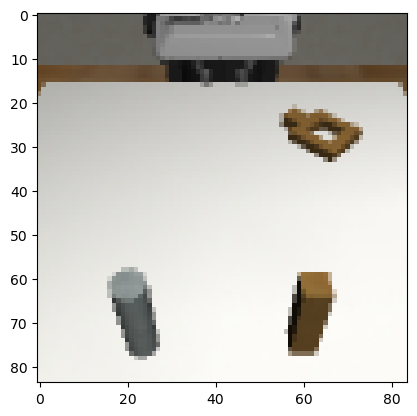

In [34]:
cur_im = data['data']['demo_0']['obs']['agentview_image'][0]
plt.imshow(cur_im)

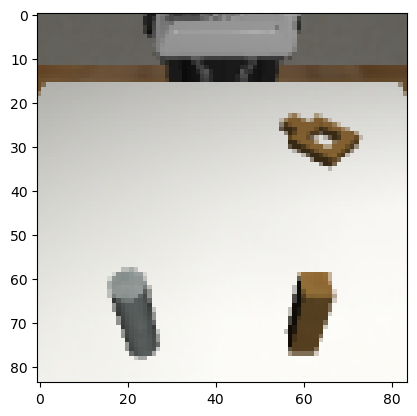

In [33]:
next_im = data['data']['demo_0']['next_obs']['agentview_image'][0]
plt.imshow(next_im)

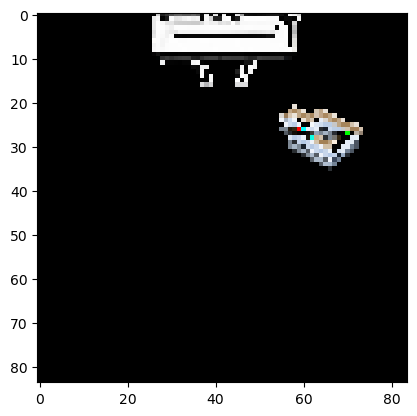

In [39]:
plt.imshow(cur_im - next_im)

## Obs encoder playing

In [23]:
"""
A simple example showing how to construct an ObservationEncoder for processing multiple input modalities.
This is purely for instructional purposes, in case others would like to make use of or extend the
functionality.
"""

from collections import OrderedDict

import torch
from robomimic.models.base_nets import MLP
from robomimic.models.obs_nets import ObservationEncoder, ObservationDecoder
from robomimic.models.base_nets import CropRandomizer
import robomimic.utils.tensor_utils as TensorUtils
import robomimic.utils.obs_utils as ObsUtils

obs_encoder = ObservationEncoder(feature_activation=torch.nn.ReLU)

# There are two ways to construct the network for processing a input observation.

# 1. Construct through keyword args and class name

# Assume we are processing image input of shape (3, 224, 224).
camera1_shape = [3, 224, 224]

# We will use a reconfigurable image processing backbone VisualCore to process the input image observation key
net_class = "VisualCore"  # this is defined in models/base_nets.py

# kwargs for VisualCore network
net_kwargs = {
    "input_shape": camera1_shape,
    "backbone_class": "ResNet18Conv",  # use ResNet18 as the visualcore backbone
    "backbone_kwargs": {"pretrained": False, "input_coord_conv": False},
    "pool_class": "SpatialSoftmax",  # use spatial softmax to regularize the model output
    "pool_kwargs": {"num_kp": 32}
}

# register the network for processing the observation key
obs_encoder.register_obs_key(
    name="camera1",
    shape=camera1_shape,
    net_class=net_class,
    net_kwargs=net_kwargs,
)

# 2. Alternatively, we could initialize the observation key network outside of the ObservationEncoder

# The image doesn't have to be of the same shape
camera2_shape = [3, 160, 240]

# We could also attach an observation randomizer to perturb the input observation key before sending to the network
image_randomizer = CropRandomizer(input_shape=camera2_shape, crop_height=140, crop_width=220)

# the cropper will alter the input shape
net_kwargs["input_shape"] = image_randomizer.output_shape_in(camera2_shape)
net = ObsUtils.OBS_ENCODER_CORES[net_class](**net_kwargs)

obs_encoder.register_obs_key(
    name="camera2",
    shape=camera2_shape,
    net=net,
    randomizer=image_randomizer,
)

# ObservationEncoder also supports weight sharing between keys
camera3_shape = [3, 224, 224]
obs_encoder.register_obs_key(
    name="camera3",
    shape=camera3_shape,
    share_net_from="camera1",
)

# We could mix low-dimensional observation, e.g., proprioception signal, in the encoder
proprio_shape = [12]
net = MLP(input_dim=12, output_dim=32, layer_dims=(128,), output_activation=None)
obs_encoder.register_obs_key(
    name="proprio",
    shape=proprio_shape,
    net=net,
)

# Before constructing the encoder, make sure we register all of our observation keys with corresponding modalities
# (this will determine how they are processed during training)
obs_modality_mapping = {
    "low_dim": ["proprio"],
    "rgb": ["camera1", "camera2", "camera3"],
}
ObsUtils.initialize_obs_modality_mapping_from_dict(modality_mapping=obs_modality_mapping)

# Finally, construct the observation encoder
obs_encoder.make()

# pretty-print the observation encoder
print(obs_encoder)

# Construct fake inputs
inputs = {
    "camera1": torch.randn(camera1_shape),
    "camera2": torch.randn(camera2_shape),
    "camera3": torch.randn(camera3_shape),
    "proprio": torch.randn(proprio_shape)
}

# Add a batch dimension
inputs = TensorUtils.to_batch(inputs)

# Send to GPU if applicable
if torch.cuda.is_available():
    inputs = TensorUtils.to_device(inputs, torch.device("cuda:0"))
    obs_encoder.cuda()

# output from each obs key network is concatenated as a flat vector.
# The concatenation order is the same as the keys are registered
obs_feature = obs_encoder(inputs)

print(obs_feature.shape)

# A convenient wrapper for decoding the feature vector to named output is ObservationDecoder
obs_decoder = ObservationDecoder(
    input_feat_dim=obs_encoder.output_shape()[0],
    decode_shapes=OrderedDict({"action": (7,)})
)

# Send to GPU if applicable
if torch.cuda.is_available():
    obs_decoder.cuda()

print(obs_decoder(obs_feature))

/users/dreilly1/.conda/envs/robo/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/users/dreilly1/.conda/envs/robo/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ObservationEncoder(
    Key(
        name=camera1
        shape=[3, 224, 224]
        modality=rgb
        randomizer=None
        net=VisualCore(
          input_shape=[3, 224, 224]
          output_shape=[64]
          backbone_net=ResNet18Conv(input_channel=3, input_coord_conv=False)
          pool_net=SpatialSoftmax(num_kp=32, temperature=1.0, noise=0.0)
        )
        sharing_from=None
    )
    Key(
        name=camera2
        shape=[3, 160, 240]
        modality=rgb
        randomizer=CropRandomizer(input_shape=[3, 160, 240], crop_size=[140, 220], num_crops=1)
        net=VisualCore(
          input_shape=[3, 140, 220]
          output_shape=[64]
          backbone_net=ResNet18Conv(input_channel=3, input_coord_conv=False)
          pool_net=SpatialSoftmax(num_kp=32, temperature=1.0, noise=0.0)
        )
        sharing_from=None
    )
    Key(
        name=camera3
        shape=[3, 224, 224]
        modality=rgb
        randomizer=None
        net=VisualCore(
          input